# Stratified analysis of case-crossover or case-control data

## Important note

*This analysis is based on simulated data. These are not results of an actual study and no conclusions about the effect of stressful life events on triggering self-poisonig should be drawn from them. I created this notebook only to demonstrate how similar data can be analysed and presented in R. However, sample structure and frequencies of occurrence of stressful life events are based on data from actual, smaller sample of patienst who self-poisoned (n = 124).*  

In [14]:
#packages
library(tidyverse)
library(survival)
library(cowplot)

In [15]:
#plots theme
my_theme <-   theme_half_open(12) +
 theme(
    plot.margin = margin(30, 10, 30, 20),
    plot.title = element_text(face = "bold.italic", size = 12, hjust = 0, vjust = 10, color = "gray20"),
    plot.title.position = "plot",
    axis.title = element_text(face = "italic", color = "gray20"),
    axis.title.x = element_text(vjust = -5),
    axis.title.y = element_text(vjust = 5),
    axis.text = element_text(color = "gray20"),
    legend.position = "top",
    legend.margin = margin(c(5,5,10,0)),
    legend.title = element_text(face = "italic"),
    legend.text = element_text(margin = margin(r = 10, unit = "pt")),
    plot.caption.position = "panel",
    plot.caption = element_text(size = 8, face = "italic", color = "grey30", vjust = -10),
    strip.text = element_text(face = "bold")
  )
theme_set(my_theme)

#set options to display bigger plots in jupyter notebook
options(repr.plot.width = 7, 
  repr.plot.height = 5, 
  repr.plot.res = 240)

In [16]:
#dataset
events_data <- read_tsv("dataset_.tsv")

Parsed with column specification:
cols(
  id = col_double(),
  women = col_logical(),
  psychiatric_history = col_logical(),
  depression = col_logical(),
  attempts = col_logical(),
  day = col_character(),
  exposure = col_logical(),
  outcome = col_logical()
)



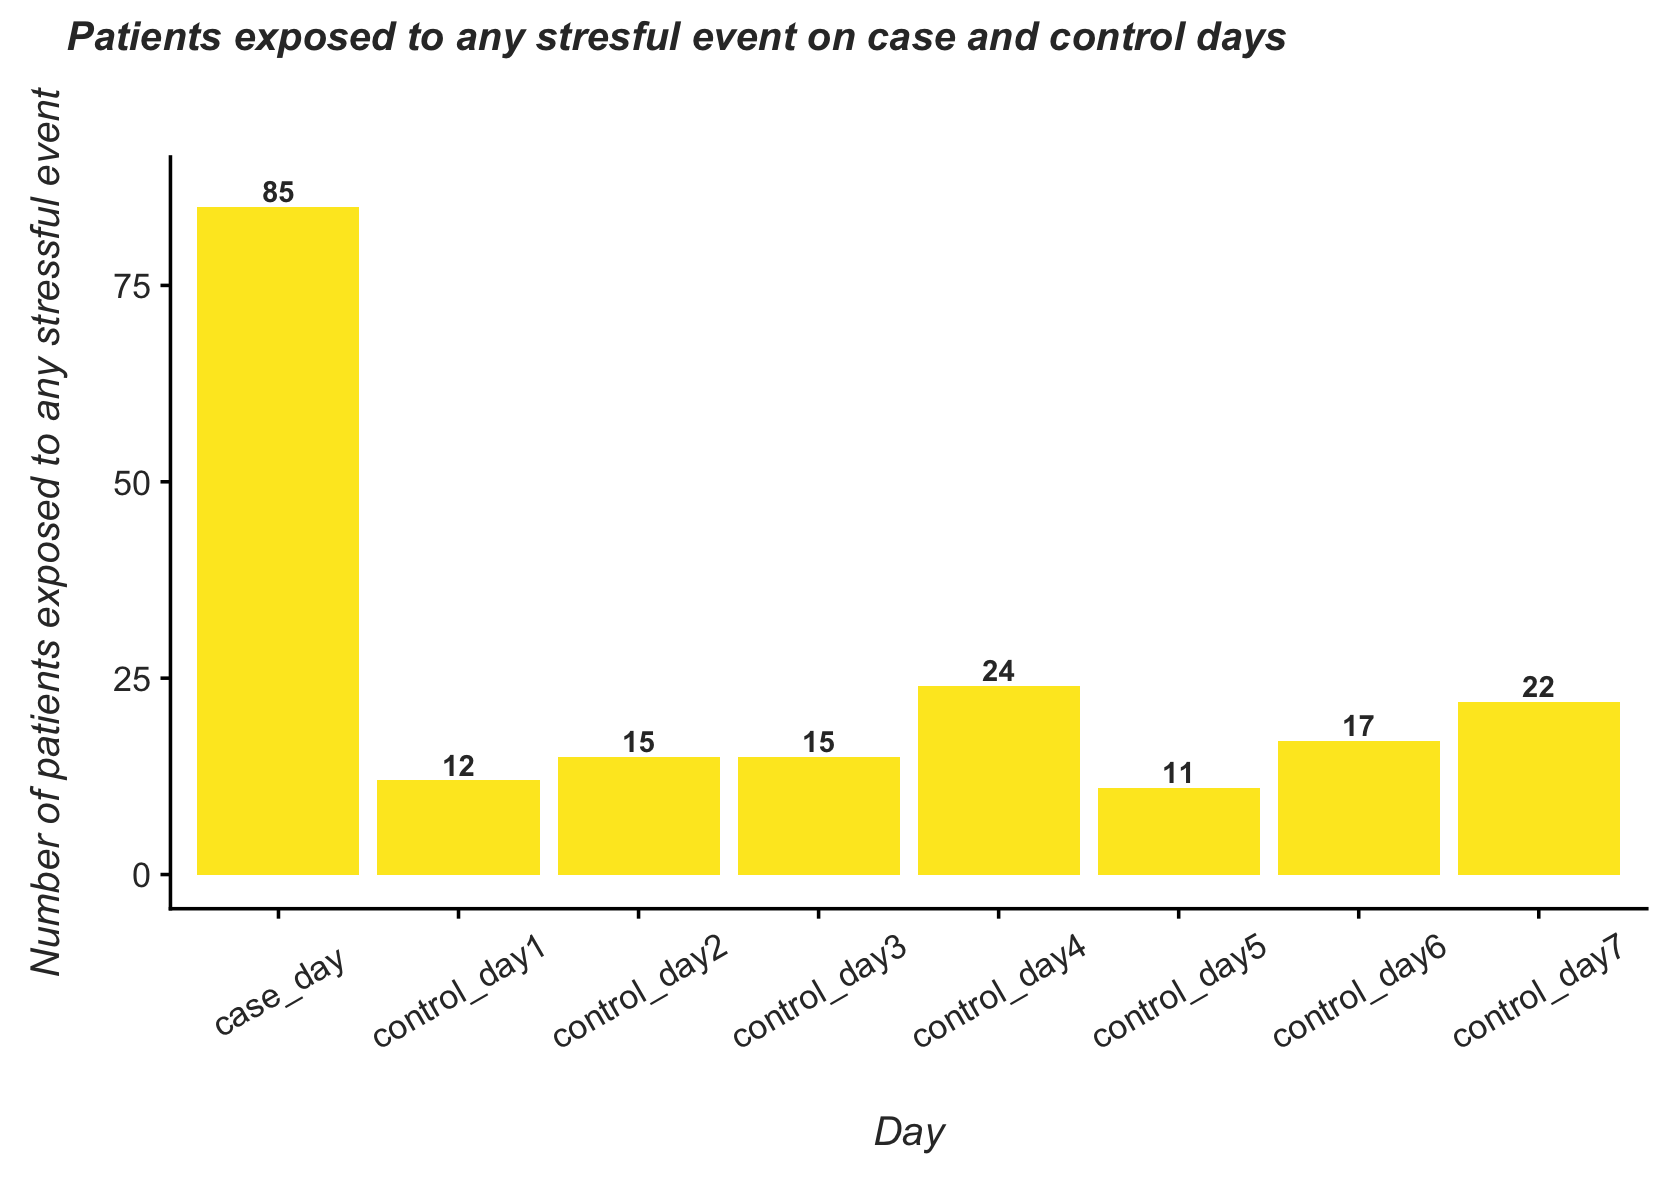

In [17]:
exposures_per_day <- events_data %>%
filter(exposure) %>%
group_by(day) %>%
summarise(count = n())

ggplot(data = exposures_per_day, aes(x = day)) +
  geom_bar(aes(weight = count, fill = ""), show.legend = FALSE) +
  geom_text(aes(y = count, label = count, fontface ="bold"),
    nudge_y = 2,
    size = 3.1,
    hjust = "middle",
    color = "gray20") +
  labs(
    x = "Day",
    y = "Number of patients exposed to any stressful event",
    title = "Patients exposed to any stresful event on case and control days"
  ) +
  theme(axis.text.x = element_text(angle = 30, vjust = 0.5)) +
  scale_fill_manual(values = "#FDE725FF")

In [18]:
create_outcome_plot <- function(dtst, gv, gv_label_false, gv_label_true) {
  if(!missing(gv)){
    gv <- enquo(gv)
    outcome_plot_data <- dtst %>%
    mutate(group = !!gv) %>%
    group_by(group, exposure, outcome)
    }else{
    outcome_plot_data <- dtst %>%
    group_by(exposure, outcome)
    }

  outcome_plot_data <- outcome_plot_data %>%
  summarise(weight = n()) %>%
  mutate(weight_string = paste0("n = ", weight)) %>%
  arrange(desc(exposure), desc(outcome))

  outcome_plot <- ggplot(data = outcome_plot_data, aes(x = exposure, y = weight)) +
  geom_col(aes(fill = outcome), position = "fill", width = 0.65) +
  geom_text(aes(label = weight_string),
    position = position_fill(vjust = 0.5),
    size = 3,
    color = "gray90",
    fontface = "bold") +
  coord_flip() +
  scale_fill_manual(values = c("#21908CFF", "#440154FF"), labels = c("no self-poisoning", "self-poisoning")) +
  scale_x_discrete(labels = c("no", "yes")) +
  labs(
    y = "proportion of patients",
    x = "exposure to stressful life event",
    fill = element_blank())

  if(!missing(gv)){
    mk_lbls <- function(string){
      if_else(string == "TRUE", gv_label_true, gv_label_false)
    }
    outcome_plot <- outcome_plot +
    facet_wrap(~ group, labeller = labeller(group = mk_lbls), ncol = 1)
    }else{}

  return(outcome_plot)
}

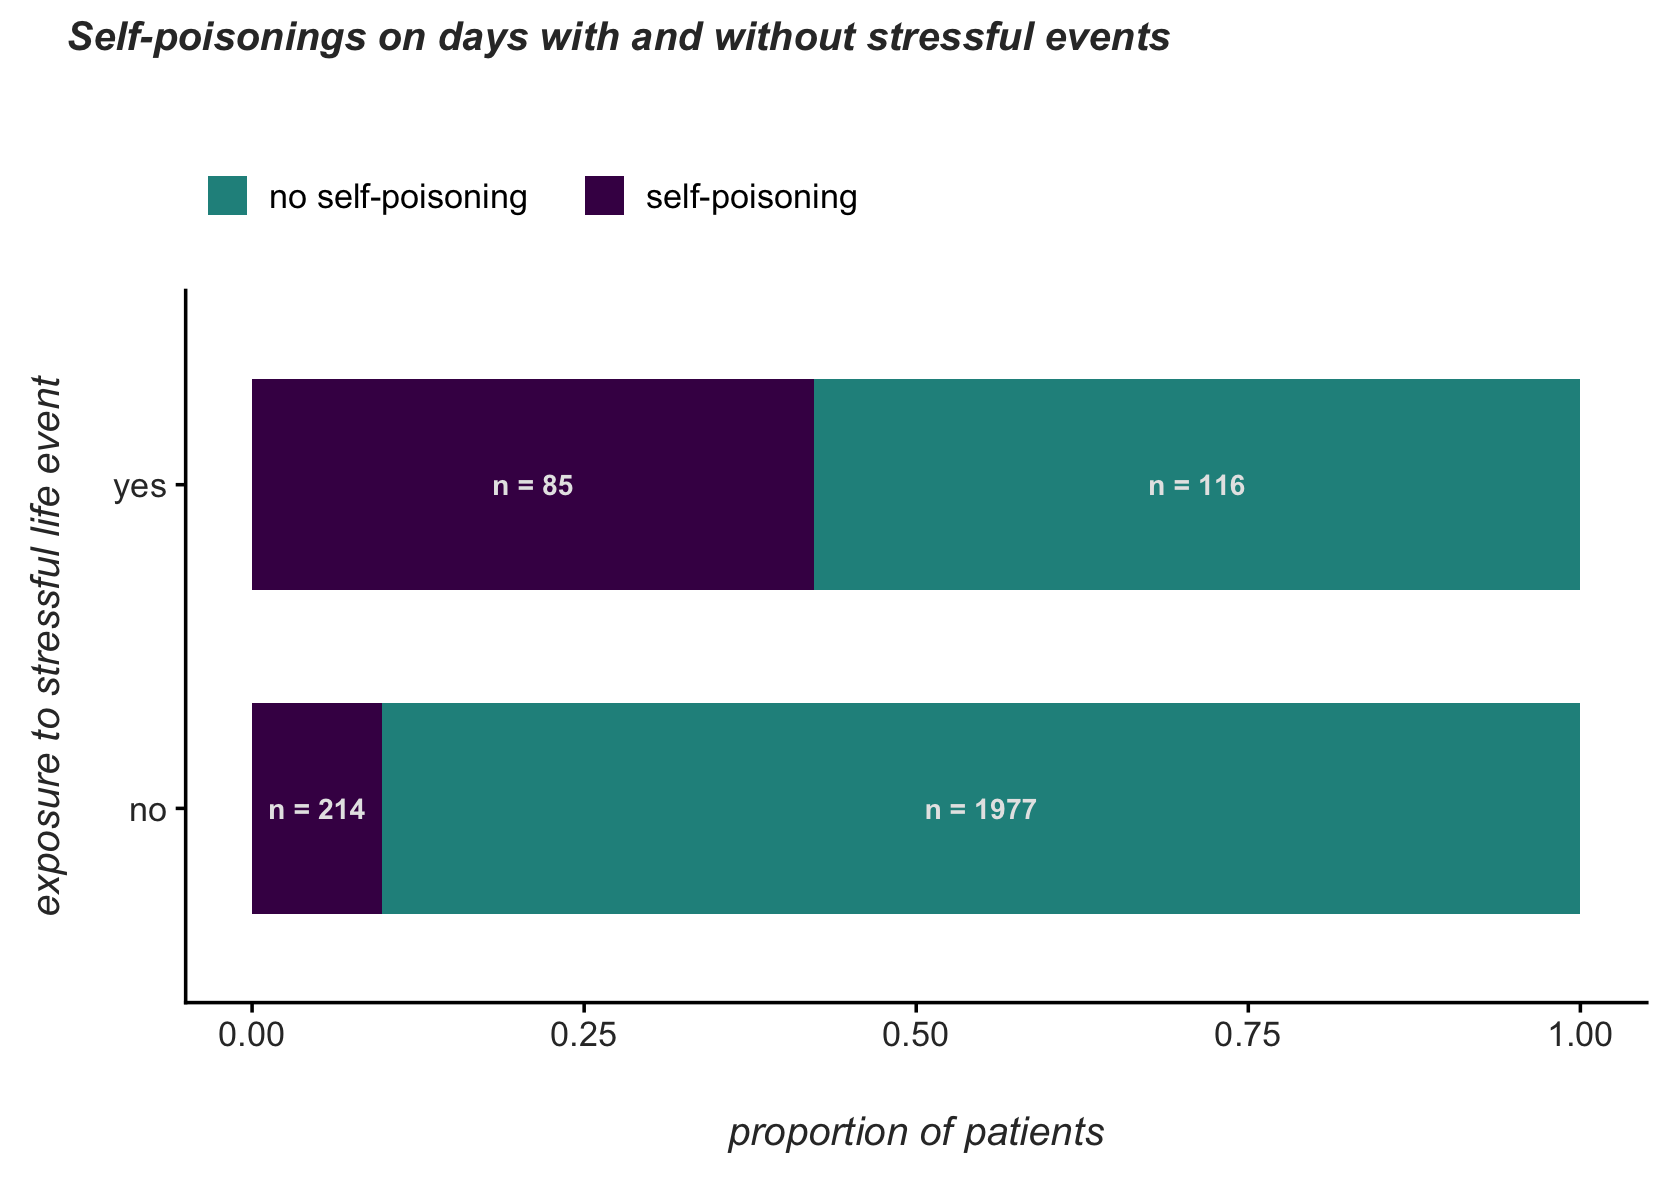

In [19]:
outcome_plot_all <- create_outcome_plot(events_data) +
  labs(title = "Self-poisonings on days with and without stressful events")
outcome_plot_all

In [20]:
#all data model
all <- clogit(outcome ~ exposure + strata(id),
  data = events_data)
summary(all)

Call:
coxph(formula = Surv(rep(1, 2392L), outcome) ~ exposure + strata(id), 
    data = events_data, method = "exact")

  n= 2392, number of events= 299 

               coef exp(coef) se(coef)     z Pr(>|z|)    
exposureTRUE 1.9148    6.7858   0.1646 11.63   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
exposureTRUE     6.786     0.1474     4.915     9.369

Concordance= 0.614  (se = 0.014 )
Likelihood ratio test= 125.7  on 1 df,   p=<2e-16
Wald test            = 135.4  on 1 df,   p=<2e-16
Score (logrank) test = 176.1  on 1 df,   p=<2e-16


In [21]:
plots_for_grid <- function(plot) {
  new_plot <- plot +
    theme(legend.position = "none", 
          plot.margin = margin(l = 20, r = 10, t = 0, b = 0),
          axis.title.x = element_blank(),
          axis.text.x = element_blank()
         ) +
    labs(title = element_blank()) 
  return(new_plot)
}

In [22]:
#plot_women
plot_women <- plots_for_grid(create_outcome_plot(events_data, women,
  gv_label_false = "men",
  gv_label_true = "women") +
labs(title = "Number of self-poisonings"))

In [23]:
#plot_psychiatric_history
plot_psychiatric_history <- plots_for_grid(create_outcome_plot(events_data, psychiatric_history,
  gv_label_false = "patients who didn't receive previous psychiatric treatment",
  gv_label_true = "patients who received previous psychiatric treatment") +
labs(title = "Number of self-poisonings"))

In [24]:
#plot_depression
plot_depression <- plots_for_grid(create_outcome_plot(events_data, depression,
  gv_label_false = "patients not diagnosed with depression",
  gv_label_true = "patients diagnosed with depression") +
labs(title = "Number of self-poisonings"))

In [25]:
#plot_attempts
plot_attempts <- plots_for_grid(create_outcome_plot(events_data, attempts,
  gv_label_false = "patients who didn't make previous suicide attempts",
  gv_label_true = "patients who made previous suicide attempts") +
labs(title = "Number of self-poisonings"))

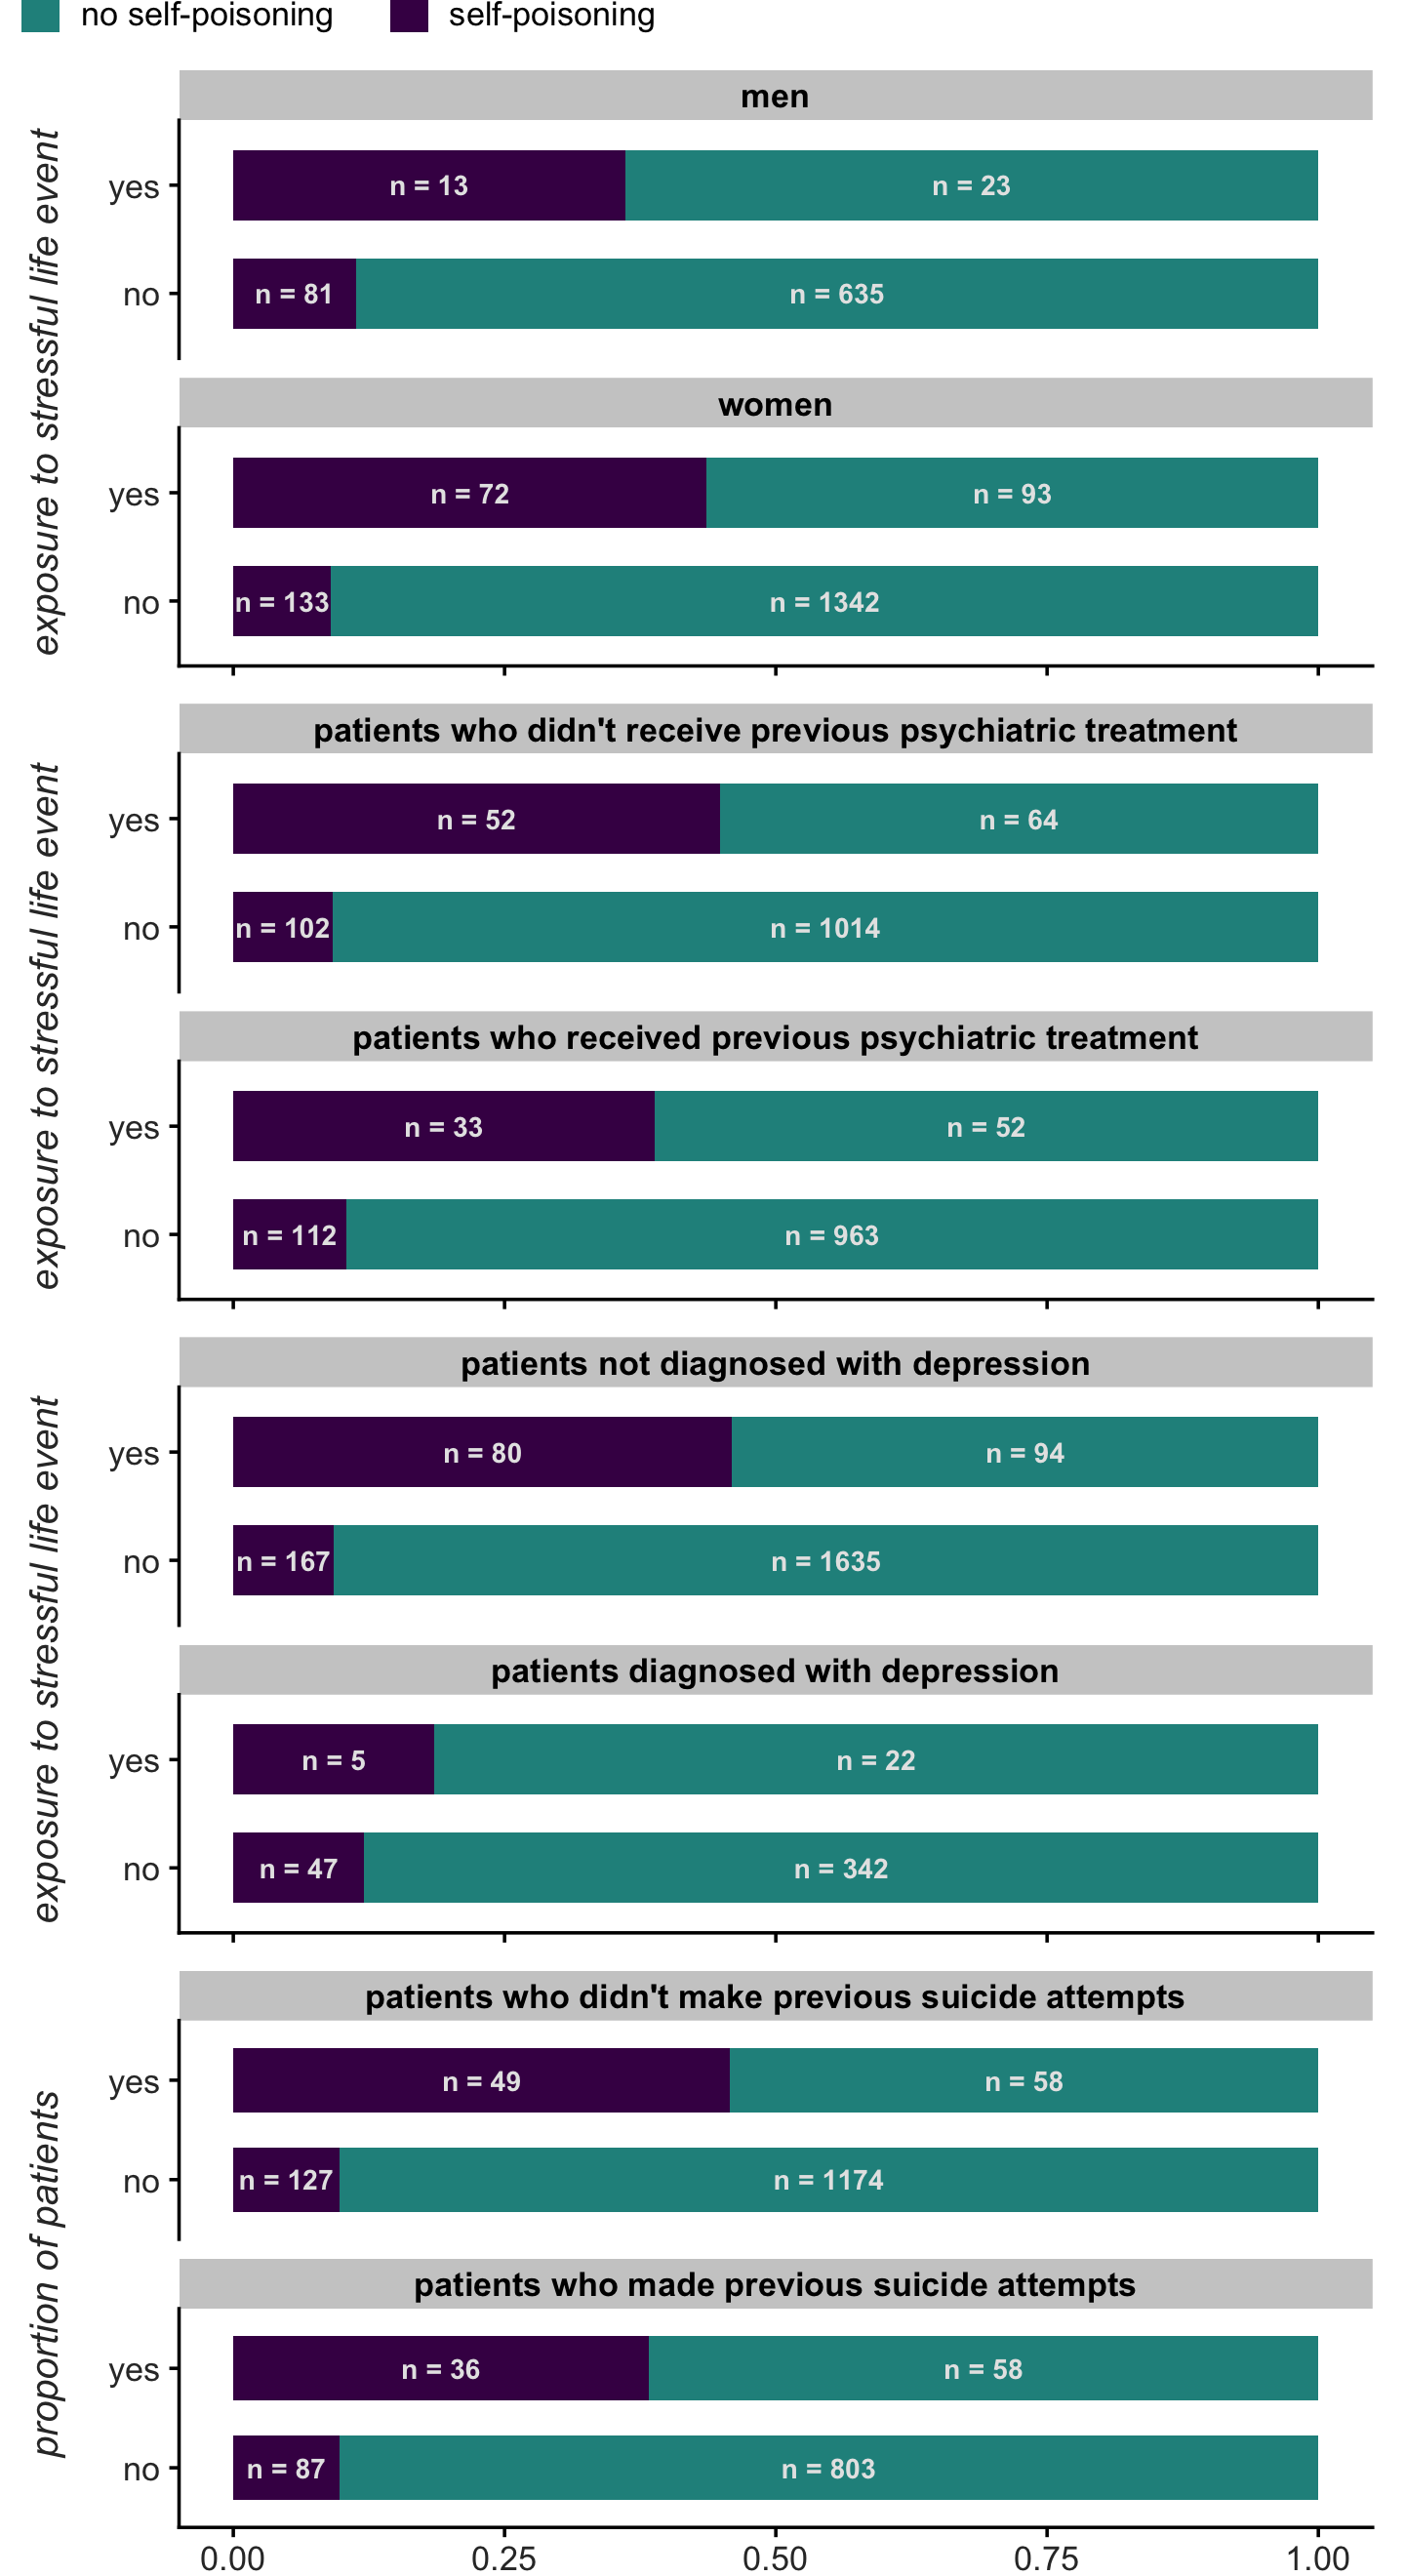

In [28]:
options(repr.plot.width = 6, repr.plot.height = 11)
legend <- get_legend(outcome_plot_all)
plot_grid(legend,
          plot_women, 
          plot_psychiatric_history, 
          plot_depression, 
          plot_attempts + 
              theme(axis.text.x = element_text()) + 
              labs(x = "proportion of patients"), 
          ncol = 1,
          rel_heights = c(0.1, 1.5, 1.5, 1.5, 1.5)
         )

In [ ]:
#function which returns OR with confidence intervals for specified goups
#also returns RR with p value
#takes dataset with so specified vars as an argument:
  #outcome var is named outcome,
  #exposure var is named exposure
  #clogit strata var is named id
#gouping_var is passed as a string

ORs_in_groups <- function(dataset, grouping_var) {
  false_group <- clogit(outcome ~ exposure + strata(id),
    data = dataset %>% filter(!dataset[[grouping_var]]))
  true_group <- clogit(outcome ~ exposure + strata(id),
    data = dataset %>% filter(dataset[[grouping_var]]))
  full_model <- clogit(outcome ~ exposure*dataset[[grouping_var]] + strata(id),
  data = dataset)
  ORs <- data.frame(
    group = paste0(grouping_var, c(":FALSE", ":TRUE")),
    OR = c(
      summary(false_group)$conf.int[ , "exp(coef)"],
      summary(true_group)$conf.int[ , "exp(coef)"]
      ),
    OR_lower_95 = c(
      summary(false_group)$conf.int[ , "lower .95"],
      summary(true_group)$conf.int[ , "lower .95"]
      ),
    OR_upper_95 = c(
      summary(false_group)$conf.int[ , "upper .95"],
      summary(true_group)$conf.int[ , "upper .95"]
      ),
    RR = rep(summary(full_model)$coefficients[3, "exp(coef)"], 2),
    RR_p_value = rep(summary(full_model)$coefficients[3, "Pr(>|z|)"], 2)
   )
  ORs <- ORs %>%
  mutate (RR_sig = case_when(
    RR_p_value < 0.1 & RR_p_value >= 0.05 ~ paste0("ns, p = ", round(RR_p_value, digits = 3)),
    RR_p_value < 0.05 & RR_p_value >= 0.01 ~ "* p < 0.05",
    RR_p_value < 0.01 & RR_p_value >= 0.001 ~ "** p < 0.01",
    RR_p_value < 0.001 ~ "*** p < 0.001",
    TRUE ~ "ns"
    )) %>%
  mutate(stars = case_when(
    RR_p_value < 0.1 & RR_p_value >= 0.05 ~ "+",
    RR_p_value < 0.05 & RR_p_value >= 0.01 ~ "*",
    RR_p_value < 0.01 & RR_p_value >= 0.001 ~ "**",
    RR_p_value < 0.001 ~ "***",
    TRUE ~ ""))
  return(ORs)
}

In [ ]:
women_ORs <- ORs_in_groups(events_data, "women")
psychiatric_history_ORs <- ORs_in_groups(events_data, "psychiatric_history")
depression_ORs <- ORs_in_groups(events_data, "depression")
attempts_ORs <- ORs_in_groups(events_data, "attempts")
stratified_ORs <- rbind(women_ORs, psychiatric_history_ORs, depression_ORs, attempts_ORs)
stratified_ORs$grouping_var <- substring(stratified_ORs$group, 1, regexpr(":", stratified_ORs$group) - 1)
stratified_ORs$grouping_var <- recode(stratified_ORs$grouping_var,
  "women" = "women",
  "psychiatric_history" = "psychiatric treatment history",
  "depression" = "depression diagnosis",
  "attempts" = "previous suicide attempts")
stratified_ORs$grouping_var_level <- substring(stratified_ORs$group, regexpr(":", stratified_ORs$group) + 1)
stratified_ORs <- stratified_ORs %>%
mutate(grouping_var_rr = paste0(grouping_var,
  ": RR = ",
  round(RR, digits = 2),
  stars))

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 7)

ggplot(data = stratified_ORs, aes(x = OR, y = grouping_var_level)) +
  geom_point() +
  geom_errorbar(aes(xmin = OR_lower_95, xmax = OR_upper_95), width = 0.2) +
  geom_vline(xintercept = 1, color = "red") +
  scale_x_continuous(breaks = seq(0, 12.5, by = 1)) +
  facet_wrap(~ grouping_var_rr, ncol = 1, as.table = FALSE) +
  theme(axis.title.y = element_blank()) +
  labs(title = "Comparison of ORs in strata",
    caption = "RR significance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, + p < 0.1\n
    Red line indicates OR = 1")